The goal is using image of handwritten digit output the value of this digit.  

**Input:**
![title](img/handdigit.png)
**Output**
the value 6

This is all the import we need.

In [98]:
from torch import nn
import torch
import numpy
from torch.autograd import Variable
import random
from numpy import genfromtxt
import torchvision.transforms as transforms

We are going to extract the data from the file train_small  
X will contains lists of value between 0 -> 255 each list represent an image  
Y will contains lists of 10 values.  
For an image of **8**:  
**[0,0,0,0,0,0,0,0,1,0]**  
The index of the 1 correspond to the value of the digit in the image  
![title](img/matrix.png)


In [99]:
data  = genfromtxt("train_small.csv", delimiter=",")
data = data[1:] #remove csv info row
X = [] #our input aka pixels value
Y = [] #our output aka the number
for elm in data:
	y = [0] * 10 #Array of 10 elm for each digit
	y[int(elm[0])] = 1 #Put a one to the corresponding index
	Y.append(y)
	X.append(elm[1:]) #get pixel value and remove the label data


Let split the data in four different variable:  
X, Y input and output for the training  
text_x, test_y for the test part  

In [100]:
store_x = X
store_y = Y
X = store_x[:int(len(X) * 0.75)] # Take 75% of the data in the X
Y = store_y[:int(len(Y) * 0.75)] # Take 75% of the data in the Y

test_x = store_x[int(len(X) * 0.75):] # Take the last 25% for testing
test_y = store_y[int(len(Y) * 0.75):]

Let's define our Neural network.  
The __init__ method is the constructor for our Network.  
In this method we define the structure of the Network.  
The forward method is used to generate output from the input(x).  
Using the different layers we defined in __init__  

In [101]:
class myNN(nn.Module):
	def __init__(self, size_input, size_output):
		super(myNN, self).__init__()
		self.layer1 = nn.Sequential(nn.Linear(size_input, 400), nn.ReLU(),)
		self.layer2 = nn.Sequential(nn.Linear(400, 200), nn.ReLU(),)
		self.layer3 = nn.Sequential(nn.Linear(200, size_output), nn.Softmax(),)
	def forward(self, x):
		x = self.layer1(x)
		x = self.layer2(x)
		output = self.layer3(x)
		return output


Let's define everything we need for the training  
First we create our Network.  
And put X and Y in object that pytorch can use.   
The learning rate and iteration number is our hyperparamter.  
The loss Function is the mathematical function that will calculate the error(also called loss)  
And finally the optimizer is a way to make the learning evolve through the training.  

In [102]:
my_nn = myNN(len(X[0]), 10)
trans = transforms.Normalize((0.5,), (1.0,))
print(type(X[0][0]))

X = Variable(trans(torch.FloatTensor(X)))
Y = Variable(torch.FloatTensor(Y))

learning_rate = 0.0001
iteration = 400
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(my_nn.parameters(), lr=learning_rate)

<class 'numpy.float64'>


So this is the loop of training  
We are going to repeat this process the number of iteration we defined above.  
First lets generate the corresponding output from the input X   
Then using the loss_function **we can calculate the error between the output and Y(What we expected as output)**  
The backward method **calculate how the weights should be updta according to the loss value.**  
And then we can say to the optimizer to update the weights according to the learning rate  
Wait a little bit because training can be long.  

[ 0.15612945] At epoch nb:  0
[ 0.01140569] At epoch nb:  50
[ 0.00490994] At epoch nb:  100
[ 0.00312008] At epoch nb:  150
[ 0.00250018] At epoch nb:  200
[ 0.00213006] At epoch nb:  250
[ 0.00180242] At epoch nb:  300
[ 0.0015739] At epoch nb:  350


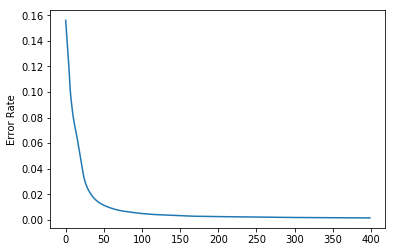

In [103]:
loss_history = []
for i in range(iteration):
    output = my_nn(X)
    loss = loss_func(output, Y)
    optimizer.zero_grad()
    loss.backward()
    loss_history.append(loss.data.numpy()[0])
    optimizer.step()
    if i % 50 == 0:
        print(loss.data.numpy(), "At epoch nb: ", i)
import matplotlib.pyplot as plt
plt.plot(loss_history)
plt.ylabel('Error Rate')
plt.show()

Now we need to test if what we have done is good or not.  
Let initialize the number of error to 0.  
then we generate an output from the test_set.  
In the loop we are going to compare the Neural Network prediction to what we expected.  
and increment the error variable if they are different.  

In [104]:
test_x = Variable(trans(torch.FloatTensor(test_x)))

error = 0
output = my_nn(test_x)
for elm, expected in zip(output, test_y):
	elm = elm.data.numpy()
	if numpy.argmax(elm) != expected.index(1):
		error += 1
print(error, "/", len(test_y))
print(error  * 100 / len(test_y), "%")


207 / 4375
4.731428571428571 %


Now we can test the classifier with new image
![title](img/handdigit.png)


In [105]:
import cv2
img = cv2.imread("img/handdigit.png")
img = cv2.resize(img, (28, 28))
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img.resize(28 * 28)

img  = Variable(trans(torch.FloatTensor([img.astype(float)])))
output = my_nn(img)
print(numpy.argmax(output.data.numpy()))

Variable containing:

Columns 0 to 5 
 9.4163e-15  1.8418e-20  7.8475e-03  1.8082e-03  2.9946e-24  4.7570e-09

Columns 6 to 9 
 9.9034e-01  7.1684e-07  1.6297e-06  7.8456e-07
[torch.FloatTensor of size 1x10]

6
